## Feature Reduction using Autoencoders
   #### Computer Vision Winter Semester 2020/2021 by Clemens Spielvogel
  
Autoencoders generate a reduced representation of an image. This representation contains a compressed version of the original data, similar to to result of a dimensionality reduction technique, such as PCA. Therefore, the representation at the bottleneck layer of an autoencoder can be used for selection of features for further processing by classical or deep learning techniques.

Be aware of the fact that in conventional convolutional layers for feature extraction, the learned features are based on the association of the image patterns with the output label. However, the features generated by autoencoders for feature selection are not chosen based on an assocation with outcome labels.

In [1]:
import numpy as np
import keras
from keras import Sequential, Model, layers
from keras.datasets import mnist
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import math
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [2]:
# Seeding random number generators to obtain reproducible results
seed_value = 0
os.environ['PYTHONHASHSEED']=str(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

We create a function for setting up a simple, fully-connected autoencoder model with one bottleneck layer. The number of nodes in the bottleneck layer can be dynamically modified.

In [3]:
def create_autoencoder_model(input_shape, num_bottleneck_nodes):
    """Create autoencoder model. Returns autoencoder model and encoder model as tuple"""

    input_img = layers.Input(shape=input_shape)

    encoder = layers.Dense(num_bottleneck_nodes, activation="relu")(input_img)
    encoder_model = Model(input_img, encoder)

    decoder = layers.Dense(input_shape[0], activation="sigmoid")(encoder)
    autoencoder_model = Model(input_img, decoder)

    autoencoder_model.compile(optimizer=keras.optimizers.Adam(), loss="mse")

    return autoencoder_model, encoder_model

Next, we create a function for loading up of the hand-written digits data set.

In [4]:
def load_data():
    # Load data
    (X_train, y_train), (X_test, y_test) = mnist.load_data()  # Get training and test MNIST images

    # Normalize and flatten features
    X_train = (X_train.astype(np.float32) / 255).reshape((len(X_train), np.prod(X_train.shape[1:])))
    y_train = y_train.astype(np.float32)
    X_test = (X_test.astype(np.float32) / 255).reshape((len(X_test), np.prod(X_test.shape[1:])))
    y_test = y_test.astype(np.float32)
    
    return X_train, y_train, X_test, y_test

This is where the main part starts. The data is loaded and an arbitrary sample is selected for retrieving the dimension of the instances.

In [5]:
# Load images
X_train, y_train, X_test, y_test = load_data()

# Get dimensions of example image
dims = X_train[0].shape

We set the hyperparameters, including the number of bottleneck nodes, in this case 32 and the number of epochs to 10. Next, the autoencoder model is created and trained.

In [6]:
# Set number of bottleneck_nodes and epochs
num_bottleneck_nodes = 32
num_epochs = 10

# Setup autoencoder and encoder
model, encoder = create_autoencoder_model(dims, num_bottleneck_nodes)

# Configure stopping criterion via early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=4)

# Train the autoencoder model
model.fit(X_train,
          X_train,
          epochs=num_epochs,
          validation_data=(X_test, X_test),
          shuffle=True,
          verbose=True,
          callbacks=[callback])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 59us/step - loss: 0.0317 - val_loss: 0.0155
Epoch 2/10
60000/60000 [==============================] - 3s 56us/step - loss: 0.0131 - val_loss: 0.0112
Epoch 3/10
60000/60000 [==============================] - 3s 58us/step - loss: 0.0111 - val_loss: 0.0105
Epoch 4/10
60000/60000 [==============================] - 3s 57us/step - loss: 0.0107 - val_loss: 0.0102
Epoch 5/10
60000/60000 [==============================] - 3s 57us/step - loss: 0.0105 - val_loss: 0.0102
Epoch 6/10
60000/60000 [==============================] - 4s 61us/step - loss: 0.0104 - val_loss: 0.0101
Epoch 7/10
60000/60000 [==============================] - 4s 62us/step - loss: 0.0104 - val_loss: 0.0100
Epoch 8/10
60000/60000 [==============================] - 4s 68us/step - loss: 0.0103 - val_loss: 0.0100
Epoch 9/10
60000/60000 [==============================] - 4s 74us/step - loss: 0.0103 - val_loss: 0.0099
Epoch

Using the encoder, we can retrieve the reduced representation of the data.

In [7]:
# Extract the low dimensional feature representation
reduced_X_train = encoder.predict(X_train)
reduced_X_test = encoder.predict(X_test)

The reduced features can then be used as an input for any machine learning algorithm, in this case a fully-connected neural network.

In [8]:
# Setup NN classifier
clf = MLPClassifier()

# Train classifier on reduced features
clf.fit(reduced_X_train, y_train)

C:\Users\cleme\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [9]:
# Predict outcomes using reduced test features
y_pred = clf.predict(reduced_X_test)

# Compute accuracy score
acc = accuracy_score(y_test, y_pred)

# Display performance
print("Test accuracy:", round(acc, 3))

Test accuracy: 0.973


This last part is just to give you some insights on the autoencoder. Especially when you do not get a well performing model which is trained on your reduced features, you can get some insights on why, by running the full autoencoder for reconstruction.

Original: 7
Predicted: 7
Original: 2
Predicted: 2
Original: 1
Predicted: 1


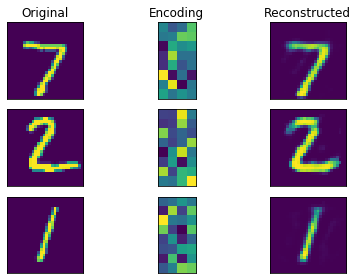

In [10]:
# Select example by index
sample_indices = [0, 1, 2]

# Display original and predicted label
for index in sample_indices:
    print("Original: {}\nPredicted: {}".format(int(y_test[sample_indices[index]]), 
                                               int(clf.predict([reduced_X_test[sample_indices[index]]]))))

# Autoencoder reconstruction
reconstructed_imgs = model.predict(X_test)

# Reshaping for plotting
X_test = X_test.reshape((len(X_test), 28, 28))
reduced_X_test = reduced_X_test.reshape(len(reduced_X_test), 8, 4)
reconstructed_imgs = reconstructed_imgs.reshape((len(X_test), 28, 28))

# Plotting
fig, ax = plt.subplots(3, 3)
params = {"top": False, "bottom": False, "left": False, "right": False, "labelleft": False,
          "labelbottom": False}

ax[0, 0].title.set_text("Original")
ax[0, 1].title.set_text("Encoding")
ax[0, 2].title.set_text("Reconstructed")

ax[0, 0].imshow(X_test[0])
ax[0, 0].tick_params(**params)
ax[0, 1].imshow(reduced_X_test[0])
ax[0, 1].tick_params(**params)
ax[0, 2].imshow(reconstructed_imgs[0])
ax[0, 2].tick_params(**params)

ax[1, 0].imshow(X_test[1])
ax[1, 0].tick_params(**params)
ax[1, 1].imshow(reduced_X_test[1])
ax[1, 1].tick_params(**params)
ax[1, 2].imshow(reconstructed_imgs[1])
ax[1, 2].tick_params(**params)

ax[2, 0].imshow(X_test[2])
ax[2, 0].tick_params(**params)
ax[2, 1].imshow(reduced_X_test[2])
ax[2, 1].tick_params(**params)
ax[2, 2].imshow(reconstructed_imgs[2])
ax[2, 2].tick_params(**params)

plt.tight_layout()
plt.show()